In [1]:
!pip install opencv-python tqdm matplotlib numpy ipywidgets
!jupyter nbextension enable --py widgetsnbextension
!pip3 install tdmclient --upgrade


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


# Computer vision

Goals : The aim of this code is :
- to stream a USB camera;
- to recognize on the video frames the robot, the starting point, the goal and the obstacles;
- to provide the respective positions of the aforthmentionned objects in a map.

The tracking of the different objects is done by template matching. The estimation of the real distances can be realized with given known references.



In [2]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import IPython
from IPython.display import display, clear_output
import time
import math




# Image Tracking

You can track the tracking(frame) of an object in an image by using what is called template matching.




In [12]:
def find_camera_index(i):
    cap = cv2.VideoCapture(i)
    if cap.isOpened():
        print(f"Camera index {i} found.")
        cap.release()
        return(i)
    else:
        print(f"No camera found at index {i}.")
        return find_camera_index(i+1)

def show_frame(frame):
    _, img_encoded = cv2.imencode('.png', frame)
    IPython.display.display(IPython.display.Image(data=img_encoded.tobytes()))

def vector_to_angle(vector):
    angle = math.atan2(vector[1], vector[0])
    return angle
        
class Object2:
    def __init__(self, pattern):
        self.pattern = pattern
        self.color, self.width, self.height = pattern.shape[::-1]
    
    def tracking(self, frame, match_treshold = 0.8):
        res = cv2.matchTemplate(frame,self.pattern,cv2.TM_CCOEFF_NORMED)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
        if max_val > match_treshold:
            pos_in_img = np.array([max_loc[0] + self.width // 2, max_loc[1] + self.height // 2])
            return pos_in_img
        else:
            return np.array([0,0])
        
    
class Map:
    def __init__(self, ref1, ref2, ref3, distance_r1r2 = 400, distance_r3r2 = 400):
        self.ref1 = ref1
        self.ref1_position  = np.array([1, 0])
        self.ref2 = ref2
        self.ref2_position = np.array([0, 0])
        self.ref3 = ref3
        self.ref3_position = np.array([0, 1])
        self.origin = np.array([0, 0])
        self.e1 = (self.ref1_position - self.ref2_position)/np.linalg.norm(self.ref1_position - self.ref2_position)
        self.e2 = (self.ref3_position - self.ref2_position)/np.linalg.norm(self.ref3_position - self.ref2_position)
        self.scale1 = distance_r1r2/np.linalg.norm(self.ref1_position - self.ref2_position)
        self.scale2 = distance_r3r2/np.linalg.norm(self.ref3_position - self.ref2_position)
        
    def loc_img2map(self, frame, img_coordinates):
        # Interpretation of an image thanks to the map
        r1_img_pos = self.ref1.tracking(frame)
        r2_img_pos = self.ref2.tracking(frame)
        r3_img_pos = self.ref3.tracking(frame)
        e1_img = r1_img_pos - r2_img_pos
        e2_img = r3_img_pos - r2_img_pos
        
        map_coordinates = np.array([np.dot(img_coordinates-r2_img_pos, e1_img)/np.dot(e1_img,e1_img), 
        np.dot(img_coordinates-r2_img_pos, e2_img)/np.dot(e2_img,e2_img)])

        return map_coordinates
    
    def vec_img2map(self, frame, img_coordinates):
        # Interpretation of an image thanks to the map
        r1_img_pos = self.ref1.tracking(frame)
        r2_img_pos = self.ref2.tracking(frame)
        r3_img_pos = self.ref3.tracking(frame)
        e1_img = r1_img_pos - r2_img_pos
        e2_img = r3_img_pos - r2_img_pos
        
        map_coordinates = np.array([np.dot(img_coordinates, e1_img)/np.dot(e1_img,e1_img), 
        np.dot(img_coordinates, e2_img)/np.dot(e2_img,e2_img)])

        return map_coordinates
    
    def map2img(self, frame, map_coordinates):
        r1_img_pos = self.ref1.tracking(frame)
        r2_img_pos = self.ref2.tracking(frame)
        r3_img_pos = self.ref3.tracking(frame)
        e1_img = r1_img_pos - r2_img_pos
        e2_img = r3_img_pos - r2_img_pos
        img_coordinates = np.round(r2_img_pos + map_coordinates[0]*e1_img + map_coordinates[1]*e2_img).astype(int)

        return img_coordinates
    
    def localize(self, frame, object2):
        img_coordinates = object2.tracking(frame)
        map_pos = self.loc_img2map(frame, img_coordinates)
        return map_pos

class Robot:
    def __init__(self, left_mark, right_mark, position = np.array([0, 0]), direction = np.array([0, 0])):
        self.left_mark = left_mark
        self.right_mark = right_mark
        self.position = position
        self.direction = direction

    def robot_tracking(self, frame):
        lm_img_pos = self.left_mark.tracking(frame)
        rm_img_pos = self.right_mark.tracking(frame)

        robot_img_pos = np.array([(lm_img_pos[0] + rm_img_pos[0])//2, (lm_img_pos[1] + rm_img_pos[1])//2])
        robot_img_direction = np.array([-(lm_img_pos[1] - rm_img_pos[1]), (lm_img_pos[0] - rm_img_pos[0])])
        return np.array([robot_img_pos, robot_img_direction])
    
    def update_localization(self, frame, map):
        robot_img_pos = self.robot_tracking(frame)[0]
        robot_img_direction = self.robot_tracking(frame)[1]
        self.position = map.loc_img2map(frame, robot_img_pos)
        dir = map.vec_img2map(frame, robot_img_direction)
        self.direction = dir/np.linalg.norm(dir)
        return
    
    def robot_localization(self, frame, map):
        self.update_localization(frame, map)
        return np.array([self.position, self.direction])


def object_highlight(drawing, original_frame, object2):
    img_coordinates = object2.tracking(original_frame)
    cv2.rectangle(drawing, [img_coordinates[0] - object2.width // 2, img_coordinates[1] - object2.height // 2], 
                    [img_coordinates[0] + object2.width // 2, img_coordinates[1] + object2.height // 2], (200, 0, 0), -1)
    return



robot_led1_template = cv2.imread('right_mark.jpg')
robot_led2_template = cv2.imread('left_mark.jpg')

left_mark = Object2(robot_led2_template)
right_mark = Object2(robot_led1_template)

robot = Robot(left_mark,right_mark)

goal_template = cv2.imread('goal.jpg')
goal = Object2(goal_template)

ref1_template = cv2.imread('ref1.jpg')
ref2_template = cv2.imread('ref2.jpg')
ref3_template = cv2.imread('ref3.jpg')

ref1 = Object2(ref1_template)
ref2 = Object2(ref2_template)
ref3 = Object2(ref3_template)

map = Map(ref1,ref2,ref3)

template_matching_on_video = []

i = 0
cap = cv2.VideoCapture(i)
# Check if camera opened successfully
""" while not cap.isOpened():
    cap = cv2.VideoCapture(i)
    print(f"No camera found at index {i}.")
    i += 1
 """
video_imgs = []
titles = []


for i in range(10):
    ret, frame = cap.read()
    if ret == True:
        copy = frame.copy()

        #print('Goal img pos :', goal.tracking(frame))
        #print('Goal map pos :', map.localize(frame,goal))
        titles.append("Frame {}, robot map loc {}, angle {}".format(i, robot.robot_localization(frame,map)[0], vector_to_angle(robot.robot_localization(frame,map)[1])))
        object_highlight(copy,frame,ref1)
        object_highlight(copy,frame,ref2)
        object_highlight(copy,frame,ref3)
        object_highlight(copy,frame,robot.left_mark)
        object_highlight(copy,frame,robot.right_mark)
        
        cv2.line(copy, robot.robot_tracking(frame)[0], np.add(robot.robot_tracking(frame)[0],robot.robot_tracking(frame)[1]), (255, 0, 0), 2)
        video_imgs.append(copy)

        show_frame(copy)
        #time.sleep(1)

        clear_output(wait=True)

    #if np.sum(abs(goal.position-robot.position) < 5) > 0:
        #break
    # Break the loop
    
        
print("There are {} frames in the video".format(len(video_imgs)))

There are 10 frames in the video


In [13]:
from ipywidgets import interact

%matplotlib inline

def browse_images(images, titles = None):
    if titles == None:
        titles = [i for i in range(len(images))]
        
    n = len(images)
    def view_image(i):
        plt.imshow(images[i], cmap=plt.cm.gray_r, interpolation='nearest')
        plt.title(titles[i], y=-0.5)
        plt.show()
    interact(view_image, i=(0,n-1))

browse_images(video_imgs, titles)

interactive(children=(IntSlider(value=4, description='i', max=9), Output()), _dom_classes=('widget-interact',)…

Define the templates of :
1) the robot : defined as a red and a green led
2) the starting point
3) the goal
4) the obstacles : blue shapes

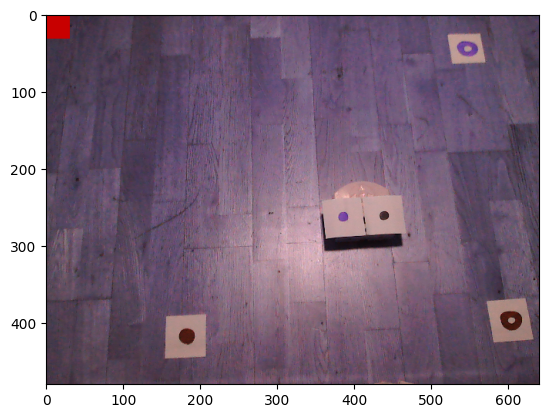

In [7]:
template = video_imgs[49]
cv2.imwrite('objects.jpg', template)

plt.imshow(template)

#cv2.imwrite('robot.jpg', template)
#cv2.imwrite('goal.jpg', template)
#cv2.imwrite('ref1.jpg', template)
#cv2.imwrite('ref2.jpg', template)
#cv2.imwrite('ref3.jpg', template)



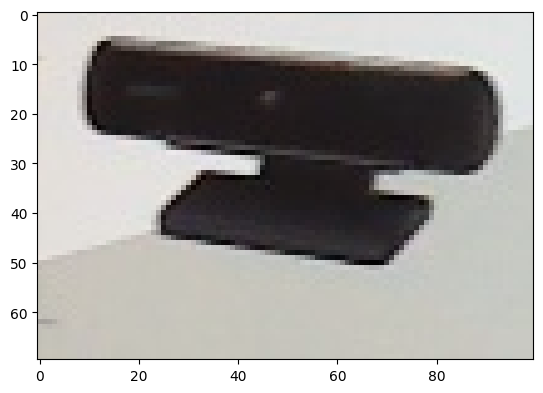

In [15]:
frame_width = int(cap.get(3)) 
frame_height = int(cap.get(4)) 
   
size = (frame_width, frame_height)
result = cv2.VideoWriter('test_tracking.mp4', cv2.VideoWriter_fourcc(*'MP4V'), 20, size)
for f in range(len(template_matching_on_video)):
    result.write(template_matching_on_video[f])
#dir = r'C:\Users\eaell\Documents\epfl\ma1\MICRO-452 Basics of mobile robotics\project'
#cv2.imwrite('test_tracking2.jpg', template)

Now have a look at the opencv tutorial [here](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_template_matching/py_template_matching.html) and apply the different template matching techniques on the image and the template. 

***Which methods seems the most robust and why?***

<span style="color: #2980B9 ;">

>Looking at the matching results, it would seem that cv2.TM_CCOEFF_NORMED gives the highest contrast between the found point and the rest.
</span>


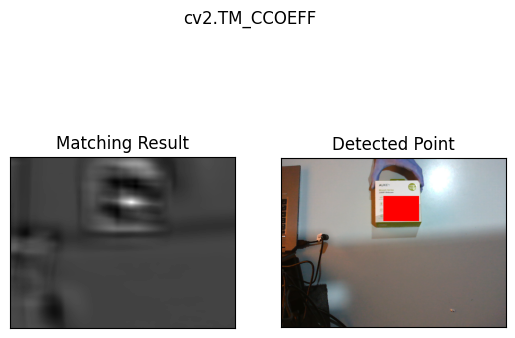

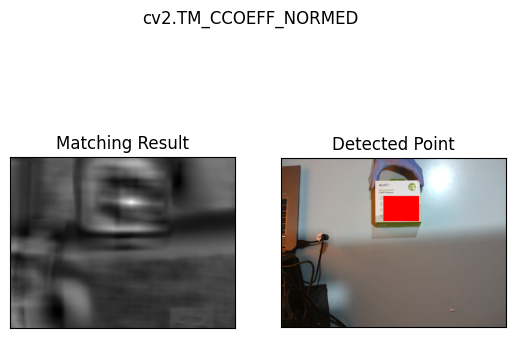

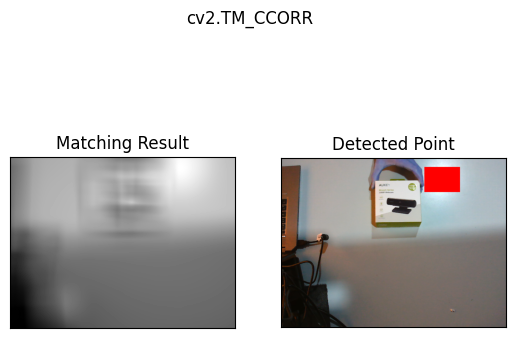

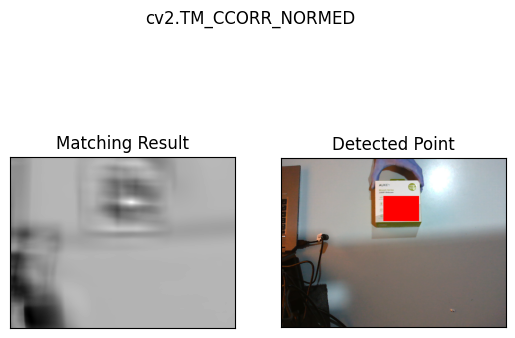

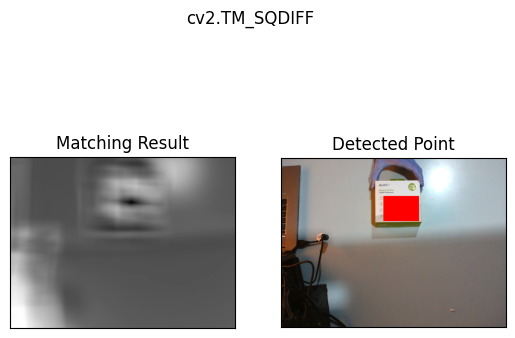

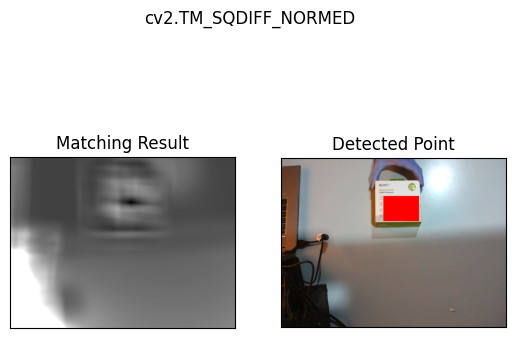

In [31]:
c, w, h  = template.shape[::-1]

methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
            'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']

for meth in methods:
    method = eval(meth)
    img = video_imgs[30].copy()
    
    # Apply template Matching
    res = cv2.matchTemplate(img,template,method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)

    cv2.rectangle(img,top_left, bottom_right, (255, 0, 0), -1)
    
    plt.figure()
    plt.subplot(121),plt.imshow(res,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(img,cmap = 'gray')
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    plt.suptitle(meth)

    plt.show()

Once you have selected the algorithm that you believe to be the most appropriate, apply it to the set of images that were extracted from the video. To visualise the result of the process, we have provided a browse images function which when provided the individual images lets you nagivate through them with a slider. 

***What are the limitations of template matching?***
  
<span style="color: #2980B9 ;">
    
> "Pattern occurrences have to preserve the orientation of the reference pattern image (template). As a result, it does not work for rotated or scaled versions of the template as a change in shape/size/shear etc. of object w.r.t. template will give a false match. The method is inefficient when calculating the pattern correlation image for medium to large images as the process is time consuming." (see [here](https://www.geeksforgeeks.org/template-matching-using-opencv-in-python/) for more details)


</span>


In [32]:
from tqdm import tqdm 

template_matching_on_video = []
titles = []

for idx_frame in tqdm(range(len(video_imgs))):
    img = video_imgs[idx_frame].copy()

    # Apply template Matching
    res = cv2.matchTemplate(img,template,cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    
    titles.append("Frame {}, top left corner of thymio located at {}".format(idx_frame, top_left))
    cv2.rectangle(img, top_left, bottom_right, (255, 0, 0), -1)
    template_matching_on_video.append(img)


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:03<00:00, 15.25it/s]


In [23]:
from ipywidgets import interact

%matplotlib inline

def browse_images(images, titles = None):
    if titles == None:
        titles = [i for i in range(len(images))]
        
    n = len(images)
    def view_image(i):
        plt.imshow(images[i], cmap=plt.cm.gray_r, interpolation='nearest')
        plt.title(titles[i], y=-0.5)
        plt.show()
    interact(view_image, i=(0,n-1))

browse_images(video_imgs, titles)


interactive(children=(IntSlider(value=24, description='i', max=49), Output()), _dom_classes=('widget-interact'…

# Robot leds setting for tracking

In [59]:
import tdmclient.notebook
await tdmclient.notebook.start()

In [60]:
leds_top=[0,0,0]
leds_bottom_left=[0,0,0]
leds_bottom_right=[0,0,0]
leds_circle = [0,0,0,0,0,0,0,0]
leds_prox_h = [32,32,32,32,32,32,32,32]
leds_prox_v = [0,0]
leds_buttons = [0,0,0,0]
leds_rc = [0]
leds_temperature = [0,0]

In [56]:
await tdmclient.notebook.stop()